# Imports

In [1]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)


# Functions

In [2]:
def load_and_preprocess(data_path):
    data = pd.read_csv(data_path)
    data['temp_celsius'] = data['temp'] - 273.15
    data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    train_df = df[:train_size]
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys), time_steps

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred)

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    test_mse = mean_squared_error(true_y_test, true_y_test_pred)
    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse



def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(figsize=(20, 10))

    # Train
    train_time = train_df.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_df.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_df.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train MSE: {train_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation MSE: {val_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test MSE: {test_mse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/malmo_one_year.csv"

# Data Preparation

In [4]:
# load and preprocess data
df = load_and_preprocess(data_path)
print(df.head())

# features and target
feature_columns=[col for col in df.columns if col != 'temp_celsius']
target_column='temp_celsius'

# split data by time
train_df, val_df, test_df = split_data_by_time(df, train_frac=0.7, val_frac=0.15)

print("Train Sizes:", train_df.shape, "Validation Sizes:", val_df.shape, "Test Sizes:", test_df.shape)

train_scaled_x, val_scaled_x, test_scaled_x, train_scaled_y, val_scaled_y, test_scaled_y, scaler_x, scaler_y = scale_data(train_df, val_df, test_df, feature_columns, target_column)

# time window
X_train, y_train, time_steps = create_timewindow(train_scaled_x, train_scaled_y, time_steps = 5)
X_val, y_val, time_steps = create_timewindow(val_scaled_x, val_scaled_y, time_steps = 5)
X_test, y_test, time_steps = create_timewindow(test_scaled_x, test_scaled_y, time_steps = 5)



             humidity  wind_speed  clouds_all     pressure   dew_point  \
date                                                                     
2022-12-31  92.000000    0.450000  100.000000   998.000000  280.870000   
2023-01-01  90.791667    8.787500   96.000000  1003.916667  281.007917   
2023-01-02  93.500000    7.887500   91.833333  1008.041667  279.700833   
2023-01-03  87.083333    8.070833   46.500000  1018.583333  275.953333   
2023-01-04  94.958333   11.200000   99.791667  1003.166667  278.899583   

            temp_celsius  
date                      
2022-12-31      8.950000  
2023-01-01      9.292917  
2023-01-02      7.535000  
2023-01-03      4.784583  
2023-01-04      6.497083  
Train Sizes: (256, 6) Validation Sizes: (54, 6) Test Sizes: (56, 6)


In [5]:
input_shape = (X_train.shape[1], X_train.shape[2])

# Model

In [6]:
model = Sequential([
        LSTM(50, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dense(1)
    ])

optimizer = Adam(learning_rate=0.001)


model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
start_time = datetime.datetime.now()

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=early_stopping
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/1000
8/8 [==============================] - 3s 85ms/step - loss: 0.3480 - mse: 0.3383 - val_loss: 0.1451 - val_mse: 0.1355
Epoch 2/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1389 - mse: 0.1292 - val_loss: 0.0322 - val_mse: 0.0226
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0971 - mse: 0.0875 - val_loss: 0.0425 - val_mse: 0.0330
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0839 - mse: 0.0745 - val_loss: 0.0266 - val_mse: 0.0174
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0624 - mse: 0.0532 - val_loss: 0.0227 - val_mse: 0.0137
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0503 - mse: 0.0413 - val_loss: 0.0202 - val_mse: 0.0113
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0377 - mse: 0.0288 - val_loss: 0.0174 - val_mse: 0.0085
Epoch 8/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0285 - mse: 0.0

# Performance Evaluation

In [8]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.006593023426830769 Validation Loss: 0.009657926857471466 Test Loss: 0.010498634539544582


In [ ]:
# RNN  Train Loss: 0.005940112750977278 Validation Loss: 0.008608177304267883 Test Loss: 0.01408026646822691
# LSTM Train Loss: 0.006593023426830769 Validation Loss: 0.009657926857471466 Test Loss: 0.010498634539544582

In [9]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.6983022000946915 Validation MSE: 4.335534849243998 Test MSE: 4.78463112770067


In [ ]:
# RNN  Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215 Test MSE: 7.5215032227643075
# LSTM Train MSE: 2.6983022000946915 Validation MSE: 4.335534849243998 Test MSE: 4.78463112770067

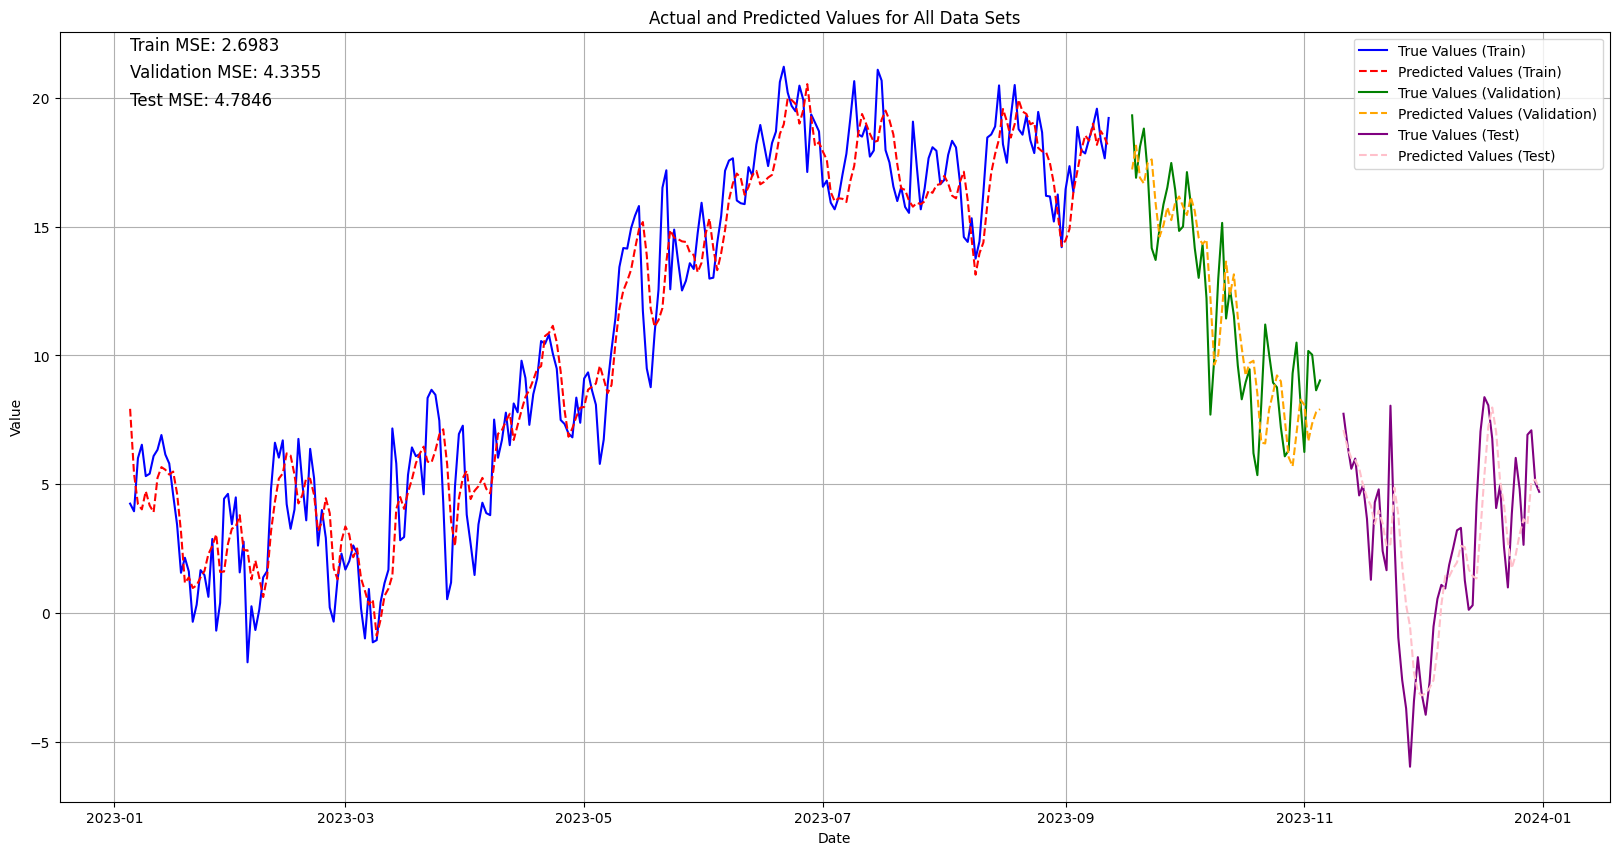

In [10]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)